In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy, time


import jax                                                 #! pip install --upgrade jax jaxlib
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries import optimizers


from sklearn.preprocessing import LabelBinarizer



# data loading ...

In [2]:
from torch_geometric.datasets import WebKB

dataset = WebKB(root='data/WebKB', name='Texas')[0] #Texas Cornell Wisconsin
dataset

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])

# X = feature vectors,    $\  $       y = class labels, $\  $  and edges

In [3]:
edge_index = np.array(dataset.edge_index)
X = np.array(dataset.x)
y = np.array(dataset.y)

y_bin = LabelBinarizer().fit_transform(y)


num_nodes, num_features = X.shape
print(f'Number of nodes = {num_nodes}, Number of features = {num_features}')

num_classes = len(np.unique(y))
print("Number of classes =", num_classes)

num_edges = edge_index.shape[1]
print("Number of edges =", num_edges)

Number of nodes = 183, Number of features = 1703
Number of classes = 5
Number of edges = 325


# Graph

# A measure of homophily and heterophily

In [4]:

homophily = 0
for i in range(num_edges):
    homophily += int(y[edge_index[0,i]]==y[edge_index[1,i]])  
    # = 1 if both nodes (connected by the edge) have same label, 0 otherwise
    


homophily =  homophily/num_edges
heterophily = 1 - homophily

print(f"homophily = {homophily:.4f}" )
print(f"heterophily = {heterophily:.4f}" )

homophily = 0.1077
heterophily = 0.8923


# Adjacency matrix

In [5]:
adj_mat = np.zeros((num_nodes, num_nodes))    
for i in range(num_edges):
    adj_mat[edge_index[0, i], edge_index[1, i]]=1    
    adj_mat[edge_index[1, i], edge_index[0, i]]=1


    
print("Is adjacency matrix symmetric:", np.mean(adj_mat == adj_mat.T)==1)


Identity_mat = np.eye(num_nodes, num_nodes) 


Is adjacency matrix symmetric: True


# Training and Test sample

In [6]:
'Random training and test splitting'

all_ids = np.arange(num_nodes)

def sample_ids(num_examples, fraction):
    ids_train = np.random.choice(num_examples, size=int(num_examples*fraction), replace=False)
    ids_test = np.array(list(set(all_ids)-set(ids_train)))
    return ids_train, ids_test

#-------------------------------------------------------------------------

np.random.seed(1)

fraction_train = 0.8
ids_train, ids_test = sample_ids(num_nodes, fraction_train)
print("ids_train =", ids_train[:10])
print("ids_test =", ids_test[:10])
print()


#-------------------------------------------------------------------------

print("Total number of nodes =", num_nodes)
print()
print("Number of training nodes =", ids_train.shape[0])
print("Number of test nodes =", ids_test.shape[0])


ids_train = [ 53  91 118 178  47 166  31 177 152 120]
ids_test = [128   1 129 133 134   7   8 137 139 140]

Total number of nodes = 183

Number of training nodes = 146
Number of test nodes = 37


$ $


# single GNN layer (Transductive learning) with Identity, Low- and High-pass filters


$ $

In [7]:




@jax.jit
def Gconv(h, Wba):                   
    Wb = Wba[0]
    W, b = Wb[:-1], Wb[-1]          # last row is bias = b, dim(W) = (num_old_features, num_new_features)
    b = b.reshape(1, b.shape[0])    # dim(b) = (1, num_new_features) is a row vector 
    
    alpha = jax.nn.softmax(Wba[1])
    A = alpha[0]*Identity_mat + alpha[1]*(Identity_mat + adj_mat) + alpha[2]*(Identity_mat - adj_mat)

    h = A @ h @ W  + b              # aggregation
    h = jax.nn.sigmoid(h)           # dim(h) = (num_nodes, num_new_features)
    return h



@jax.jit
def h_out(params, X):                          
    h = jax.nn.normalize(X)         # dim(h) = (num_papers, num_old_features)
    h = Gconv(h, params)            # 1st GNN layer
    return h



@jax.jit
def loss(params, X, y_bin, ids_train):
    h = h_out(params, X)                       # dim(h) = (num_papers, num_classes) after h_out
    h, y_bin  = h[ids_train], y_bin[ids_train] # only training nodes are used for learning
    h = jax.nn.softmax(h, axis=1)            # After softmax, each row will be normalized (sum of its entries = 1)
    return -jnp.mean(y_bin*jnp.log(h))         # cross-entropy-loss 




def accuracy(params, X, y, ids_train, ids_test):
    p_out = h_out(params, X) 
    pred = np.array([np.argmax(p) for p in p_out])     # prediction: Using the class with highest probability.
    
    compair = (pred == y)
    
    train_acc = np.sum(compair[ids_train]) / ids_train.shape[0]
    test_acc = np.sum(compair[ids_test]) / ids_test.shape[0]
    
    return train_acc, test_acc



# Training ...

(1704, 5) (3,)

Epoch: 0, Loss: 0.3219, Train acc: 0.5479, Test acc: 0.6216
Epoch: 30, Loss: 0.1875, Train acc: 1.0000, Test acc: 0.9189
Epoch: 60, Loss: 0.1830, Train acc: 1.0000, Test acc: 0.8919
Epoch: 90, Loss: 0.1818, Train acc: 1.0000, Test acc: 0.8919
Epoch: 120, Loss: 0.1816, Train acc: 1.0000, Test acc: 0.8919
Epoch: 150, Loss: 0.1814, Train acc: 1.0000, Test acc: 0.8919

time taken = 5.024761438369751


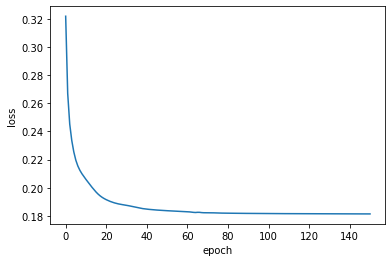

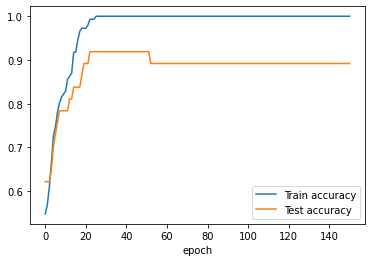

Fractions of Identity, Low- and High-pass filters in A: [0.33096728 0.31285638 0.3561764 ]


In [8]:
step_size = 0.005
eps = 1e-03
num_epoch = 151


#===========================================================================


"Initalization of learnable parameters W, b, alpha"
params = [jnp.zeros((num_features + 1, num_classes)), # = W, b
          jnp.zeros(3), # = alpha
         ] 
          


print(params[0].shape, params[1].shape)
print()


#-------------------------------------------------------------------------

opt_init, opt_update, get_params = optimizers.adam(step_size, b1=0.9, b2=0.999, eps=eps)
opt_state = opt_init(params)


def iteration(i, opt_state):                     # ids_train : only training nodes are used for learning
    value_of_loss, grads = jax.value_and_grad(loss)(get_params(opt_state), X=X, y_bin=y_bin, ids_train=ids_train)
    opt_state = opt_update(i, grads, opt_state)  # updated optimizer state
    return value_of_loss, opt_state


#===========================================================================


max_test_acc = 0
final_params = params                       # initalization


loss_acc = []
t1_start = time.time()                      # Start the stopwatch


for epoch in range(num_epoch):
    value_of_loss, opt_state = iteration(epoch, opt_state)
    Params = get_params(opt_state)
    train_acc, test_acc = accuracy(Params, X, y, ids_train, ids_test)
    
    loss_acc += [[value_of_loss, train_acc, test_acc]]
    
    if max_test_acc < test_acc and test_acc <= train_acc:
        max_test_acc = test_acc
        final_params = Params

    if epoch % 30 == 0:                  
        print(f'Epoch: {epoch}, Loss: {value_of_loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')


t1_stop = time.time()                     # Stop the stopwatch
print()
print("time taken =", t1_stop-t1_start)     


#===========================================================================



loss_acc = np.array(loss_acc)
        
plt.plot(loss_acc[:,0])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(loss_acc[:,1:], label=['Train accuracy', 'Test accuracy'])
plt.xlabel("epoch")
plt.legend()
plt.show()


#------------------------------------------------------------------------


print("Fractions of Identity, Low- and High-pass filters in A:", jax.nn.softmax(final_params[1]))

# performance evaluation:

In [9]:
print(f"number of epochs = {num_epoch}")
print(f"step_size = {step_size}")
print(f"eps = {eps}")
print(f"time taken in training (sec.) = {t1_stop-t1_start}") 
print(f"fraction of trainning examples = {fraction_train:.4f}" )
print(f'Number of nodes = {num_nodes}')
print("Number of training nodes =", ids_train.shape[0])
print("Number of test nodes =", ids_test.shape[0])



train_acc, test_acc = accuracy(final_params, X, y, ids_train, ids_test)

print("----------------------------------")
print(f"train accuracy = {train_acc:.4f}" )
print(f"test accuracy = {test_acc:.4f}" )
print("----------------------------------")

print("a sanity check:", max_test_acc == test_acc)

number of epochs = 151
step_size = 0.005
eps = 0.001
time taken in training (sec.) = 5.024761438369751
fraction of trainning examples = 0.8000
Number of nodes = 183
Number of training nodes = 146
Number of test nodes = 37
----------------------------------
train accuracy = 0.9932
test accuracy = 0.9189
----------------------------------
a sanity check: True


# visualization

/home/arun/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/arun/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


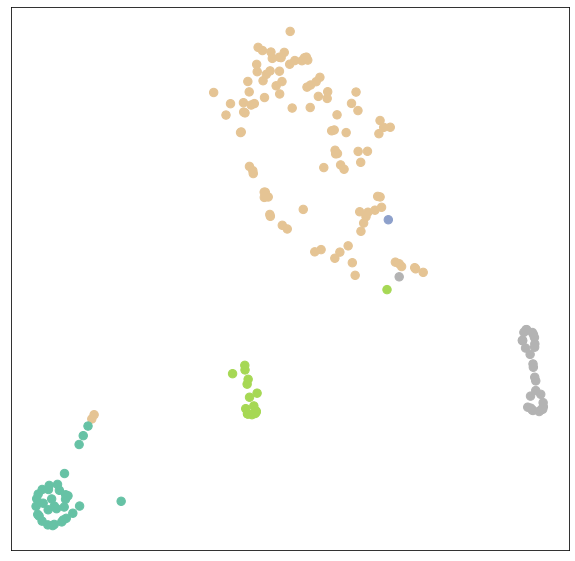

In [10]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
#------------------------------------------------------------------------

"After training"

p_out_final = h_out(final_params, X) 
visualize(p_out_final, y)

# $ $




$ $

# 2-layer GCN (transductive learning) with PyTorch Geometric

In [11]:
import torch                                                
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear  

edge_index = dataset.edge_index
X = dataset.x
y = dataset.y



In [12]:
def train():
    model.train()
    optimizer.zero_grad()                             # Clear gradients.
    out = model(X, edge_index)                        # Perform a single forward pass.
    loss = criterion(out[ids_train], y[ids_train])    # Compute the loss solely based on the training nodes.
    loss.backward()                                   # Derive gradients.
    optimizer.step()                                  # Update parameters based on gradients.
    return loss


def Accuracy():
    model.eval()
    out = model(X, edge_index)
    pred = out.argmax(dim=1)                          # prediction: Using the class with highest probability.
    
    compair = np.array(pred == y)                     # compair against ground-truth
    
    train_acc = np.sum(compair[ids_train]) / ids_train.shape[0]
    test_acc = np.sum(compair[ids_test]) / ids_test.shape[0]
    
    return train_acc, test_acc



In [13]:

def training(num_epoch):
    max_test_acc = 0                                       # initialization

    loss_acc = []
    for epoch in range(num_epoch):
        loss = train()
        train_acc, test_acc = Accuracy()
        loss_acc += [[loss.item(), train_acc, test_acc]]
        if max_test_acc < test_acc and test_acc <= train_acc:
            max_test_acc = test_acc
            torch.save(model.state_dict(), 'final_model.pt') # save final_model
    
        if epoch % 50 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')
        
    loss_acc = np.array(loss_acc)
        
    plt.plot(loss_acc[:,0])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

    plt.plot(loss_acc[:,1:], label=['Train accuracy', 'Test accuracy'])
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    print("max_test_acc =", max_test_acc)
    
    return loss_acc, max_test_acc

  
    
    
def final_repot():
    
    print(f'Number of nodes = {num_nodes}')
    print(f'Number of features = {num_features}')
    print("Number of classes =", num_classes)
    print("fraction_train =", fraction_train)
    print("learning rate =", lr)
    print("weight_decay =", weight_decay)

    model.load_state_dict(torch.load('final_model.pt'))   # load final model
    train_acc, test_acc = Accuracy()

    print("----------------------------")
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print("----------------------------")

    print("sanity check:", max_test_acc==test_acc)
    


In [14]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()                                               
        x = F.dropout(x, p=0.5, training=self.training)            
        x = self.conv2(x, edge_index)
        return x


GCN(
  (conv1): GCNConv(1703, 16)
  (conv2): GCNConv(16, 5)
)
Epoch: 000, Loss: 1.7130, Train acc: 0.5411, Test acc: 0.6216
Epoch: 050, Loss: 0.8515, Train acc: 0.7123, Test acc: 0.5135
Epoch: 100, Loss: 0.8805, Train acc: 0.7123, Test acc: 0.5676
Epoch: 150, Loss: 0.8351, Train acc: 0.7877, Test acc: 0.5135
Epoch: 200, Loss: 0.7430, Train acc: 0.7534, Test acc: 0.5946


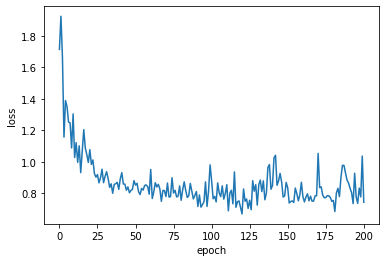

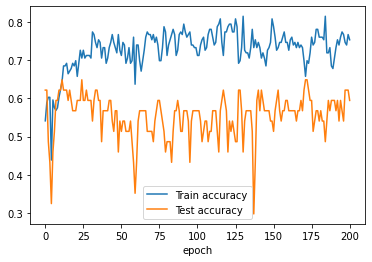

max_test_acc = 0.6486486486486487


In [15]:
lr = 0.04
weight_decay = 1e-2
num_epoch = 201
hidden_channels = 16

#----------------------------------------------------------------------

model = GCN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)  # Define model
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)                # Define optimizer
criterion = torch.nn.CrossEntropyLoss()                                                           # Define loss criterion
print(model)

#----------------------------------------------------------------------

loss_acc, max_test_acc = training(num_epoch)


In [16]:
final_repot()
print("hidden_channels =", hidden_channels)

Number of nodes = 183
Number of features = 1703
Number of classes = 5
fraction_train = 0.8
learning rate = 0.04
weight_decay = 0.01
----------------------------
Train Accuracy: 0.7055
Test Accuracy: 0.6486
----------------------------
sanity check: True
hidden_channels = 16


$ $





$ $



$ $




# Extra:




# Distributions of class-labels in whole, train, test dataset

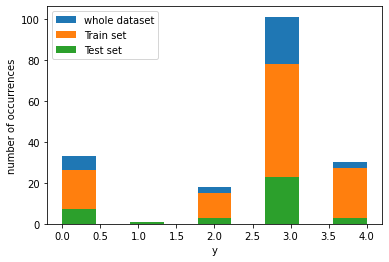

[0.18032787 0.00546448 0.09836066 0.55191257 0.16393443] = Distribution of classes in whole dataset
[0.17808219 0.         0.10273973 0.53424658 0.18493151] = Distribution of classes in Train set
[0.18918919 0.02702703 0.08108108 0.62162162 0.08108108] = Distribution of classes in Test set

normalization of distributions : 0.9999999999999999 1.0 1.0

Kullback–Leibler divergence (distance) between whole and train distributions : 0.03057920767108041
Kullback–Leibler divergence (distance) between whole and test distributions : 0.05133086178056777


In [17]:

plt.hist(np.array(y), label='whole dataset', bins=2*num_classes-1)
plt.hist(np.array(y[ids_train]), label='Train set', bins=2*num_classes-1)
plt.hist(np.array(y[ids_test]), label='Test set', bins=2*num_classes-1)
plt.legend()
plt.xlabel("y")
plt.ylabel("number of occurrences")
plt.show()


dis_whole_set = np.histogram(np.array(y), bins=num_classes)[0]/num_nodes
dis_train_set = np.histogram(np.array(y[ids_train]), bins=num_classes)[0]/ids_train.shape[0]
dis_test_set = np.histogram(np.array(y[ids_test]), bins=num_classes)[0]/ids_test.shape[0]


print(dis_whole_set, "= Distribution of classes in whole dataset")
print(dis_train_set, "= Distribution of classes in Train set")
print(dis_test_set, "= Distribution of classes in Test set")

# these distribitions should be close to each other

print()
print("normalization of distributions :", dis_whole_set.sum(), dis_train_set.sum(), dis_test_set.sum())
print()

def KL_div(p, q): # Kullback–Leibler divergence
    q=q+0.00001   # for numerical stability
    return np.dot(p, np.log(p/q))

print("Kullback–Leibler divergence (distance) between whole and train distributions :", KL_div(dis_whole_set, dis_train_set))
print("Kullback–Leibler divergence (distance) between whole and test distributions :", KL_div(dis_whole_set, dis_test_set))


# degree vector

degree vector = [  2   1   1   0   3   0   0   2   0   0   1   2   0   2   0   5   0   1
   1   0   4   0   0   2   0   2   0   0   2   3   2   0   0   0   3   0
   2   0   0   1   1   4   2   0   1   2   1   2   0   0   3   1   0   1
   1   1 104   7   5   2   2   1   0   1   1   0   1   1   0   0   1   0
   1   3   2   1   0   0   2   1   1   1   4   3   8   1   1   1   1   1
   2   0   1   0   0   5   0   0   0   3   1   1   3   0   0   1   1   1
   3   0   0   1   0   0   1   0   1   1   0   1   2   0   1   1   0   1
   3   8   0   0   1   5   0   4   1   0   0   0   0   1   3   2   0   0
   1   1   0   0   3   0   0   3   0   0   0   0   1   0   1   3   1   1
   2   2   1   0   0   0   1   0   0   5   1   7   1   1   1   3   0   0
   4   0   1]
minimum degree = 0, maximum degree = 104


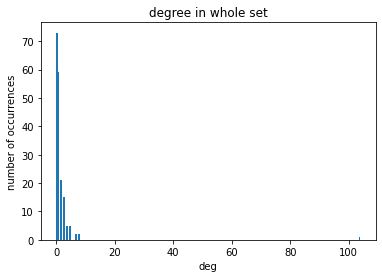

In [18]:
edges0 = edge_index[0]

deg_vec = []
for i in range(num_nodes):
    deg_vec.append(np.where(edges0==i)[0].shape[0])

deg_vec = np.array(deg_vec)
print("degree vector =", deg_vec)


min_deg, max_deg = np.min(deg_vec), np.max(deg_vec)
print(f"minimum degree = {min_deg}, maximum degree = {max_deg}")



plt.hist(deg_vec, bins=2*max_deg-1)
plt.xlabel("deg")
plt.ylabel("number of occurrences")
plt.title("degree in whole set")
plt.show()